In [2]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import os
import pickle
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight
from sklearn.metrics import precision_recall_curve, f1_score, classification_report

from tensorflow.keras import layers, models
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Conv1D, GlobalMaxPooling1D, MaxPooling1D, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC, Precision, Recall
import tensorflow.keras.backend as K

In [3]:
# Charge X and y data that are in .npy format
X = np.load('../../../save_model/X.npy')
y = np.load('../../../save_model/y.npy')
X.shape, y.shape

((241, 300, 30), (241,))

In [4]:
# Value counts of y
print(pd.Series(y).value_counts())

3    61
2    61
1    60
0    59
Name: count, dtype: int64


In [5]:
# Divide data in train, val and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape
#X_train.shape, X_test.shape, y_train.shape, y_test.shape

((153, 300, 30), (39, 300, 30), (49, 300, 30), (153,), (39,), (49,))

In [6]:
# Calculate class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

In [7]:
# Parámetros
n_components = 30  # número de componentes disponibles
n_models = 1      # número de modelos en el ensemble
components_per_model = 30  # cuantos componentes (features) por modelo

models = []
selected_components = []
histories = []

# Callback EarlyStopping y ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

# Definimos el modelo CNN
def build_cnn_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(0.0005), metrics=['accuracy'])
    return model

# Entrenamiento de ensemble
for i in range(n_models):
    print(f"Entrenando modelo {i+1}/{n_models}")
    
    # Elegimos aleatoriamente componentes
    components_idx = np.random.choice(n_components, components_per_model, replace=False)
    selected_components.append(components_idx)
    
    # Seleccionamos esos componentes
    X_train_selected = X_train[:, :, components_idx]  # (samples, 300, components_per_model)
    X_val_selected = X_val[:, :, components_idx]

    # Creamos y entrenamos el modelo
    model = build_cnn_lstm_model((X_train_selected.shape[1], X_train_selected.shape[2]))
    
    history = model.fit(
        X_train_selected,
        y_train,
        class_weight=class_weights,
        epochs=500,
        batch_size=32,
        validation_data=(X_val_selected, y_val),
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    
    models.append(model)
    histories.append(history)

Entrenando modelo 1/1
Epoch 1/500


d:\OneDrive - Universidad Peruana de Ciencias\Documents\Carrera\2025-1\TP1\videito\env\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 211ms/step - accuracy: 0.3333 - loss: 1.4769 - val_accuracy: 0.2821 - val_loss: 1.4010 - learning_rate: 5.0000e-04
Epoch 2/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.2868 - loss: 1.4437 - val_accuracy: 0.2821 - val_loss: 1.3990 - learning_rate: 5.0000e-04
Epoch 3/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.2942 - loss: 1.4290 - val_accuracy: 0.2821 - val_loss: 1.3973 - learning_rate: 5.0000e-04
Epoch 4/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.3333 - loss: 1.4044 - val_accuracy: 0.2308 - val_loss: 1.3962 - learning_rate: 5.0000e-04
Epoch 5/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.2660 - loss: 1.3968 - val_accuracy: 0.2051 - val_loss: 1.3955 - learning_rate: 5.0000e-04
Epoch 6/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.3694 - loss: 1.3526 - val_accuracy: 0.2308 - val_loss: 1.3951 - learning_rate: 5.0000e-04
Epoch 7/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.3056 - loss: 1.37

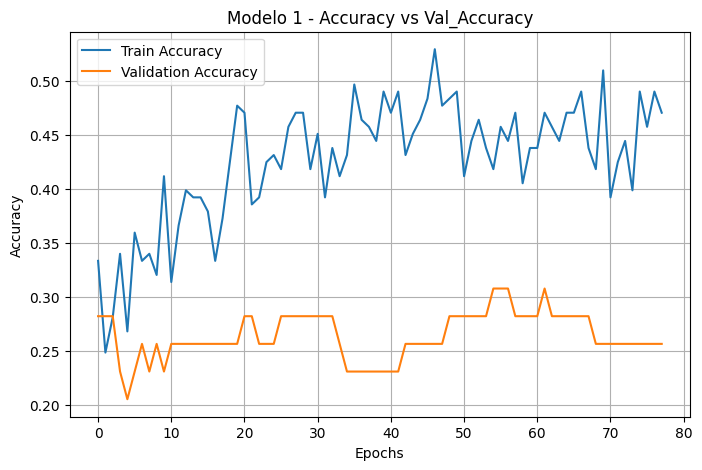

In [8]:
# Accuracy vs Val_Accuracy
for i, history in enumerate(histories):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Modelo {i+1} - Accuracy vs Val_Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

In [9]:
# Predictions of each model
all_model_preds = []

for idx, model in enumerate(models):
    components_idx = selected_components[idx]
    X_test_selected = X_test[:, :, components_idx]
    preds = model.predict(X_test_selected)
    all_model_preds.append(preds)

all_model_preds = np.stack(all_model_preds, axis=0)
avg_preds = np.mean(all_model_preds, axis=0)
final_preds = np.argmax(avg_preds, axis=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


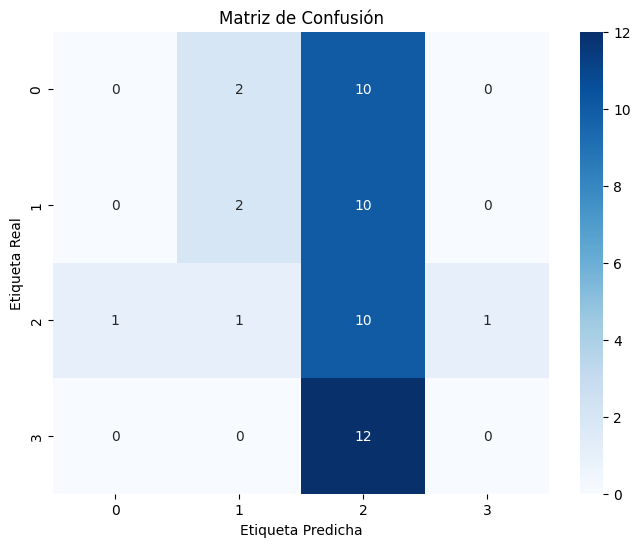

In [10]:
cm = confusion_matrix(y_test, final_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.arange(cm.shape[1]), yticklabels=np.arange(cm.shape[0]))
plt.title("Matriz de Confusión")
plt.xlabel("Etiqueta Predicha")
plt.ylabel("Etiqueta Real")
plt.show()

In [11]:
# view classification report
print(classification_report(y_test, final_preds, digits=3))

              precision    recall  f1-score   support

           0      0.000     0.000     0.000        12
           1      0.400     0.167     0.235        12
           2      0.238     0.769     0.364        13
           3      0.000     0.000     0.000        12

    accuracy                          0.245        49
   macro avg      0.160     0.234     0.150        49
weighted avg      0.161     0.245     0.154        49

